In [1]:
import cv2
import torch
import numpy as np
from glob import glob
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = np.expand_dims(X_train, -1).astype("float32") / 255
X_test = np.expand_dims(X_test, -1).astype("float32") / 255

In [3]:
classifier = tf.keras.models.load_model("./models/mnist/classifier.keras")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-05-10 11:35:44.778965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-10 11:35:44.779086: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class Generator(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
    def generate_images(self, batch_size=100):
        latent_size = 100

        fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
        generated_images = self.forward(fixed_noise)

        generated_images = generated_images.cpu().detach().numpy()
        return generated_images.reshape(generated_images.shape[0], 28, 28, 1)

In [5]:
def get_k(train_features, test_features, delta=0.005):
    k = 1
    min_space = np.min(train_features, axis=0, keepdims=True)
    max_space = np.max(train_features, axis=0, keepdims=True)
    while True:
        nn = NearestNeighbors(n_neighbors=k+1).fit(train_features)
        distances_train, _ = nn.kneighbors(train_features)
        distances_samples, indices_samples = nn.kneighbors(test_features, 1)

        num_generalized = 0
        for i in range(len(test_features)):
            train_indice = indices_samples[i]
            if distances_samples[i] > distances_train[train_indice, k] and \
                            np.all(test_features[i] > min_space) and \
                            np.all(test_features[i] < max_space):
                num_generalized += 1
        
        if num_generalized / len(test_features) < delta:
            break
        k += 1
    return k

In [6]:
def calculate_generalization(train_features, test_features, generated_features, delta=0.005):
    k = get_k(train_features, test_features, delta=delta)
    min_space = np.min(train_features, axis=0, keepdims=True)
    max_space = np.max(train_features, axis=0, keepdims=True)
    
    nn = NearestNeighbors(n_neighbors=k+1).fit(train_features)
    distances_train, _ = nn.kneighbors(train_features)
    distances_samples, indices_samples = nn.kneighbors(generated_features, 1)

    num_generalized = 0
    for i in range(len(generated_features)):
        train_indice = indices_samples[i]
        if distances_samples[i] > distances_train[train_indice, k] and \
                            np.all(generated_features[i] > min_space) and \
                            np.all(generated_features[i] < max_space):
            num_generalized += 1
    return num_generalized / len(generated_features)

2024-05-10 11:35:45.652101: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-10 11:35:45.691338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 90/313 [=======>......................] - ETA: 0s

2024-05-10 11:35:50.698911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 14ms/step


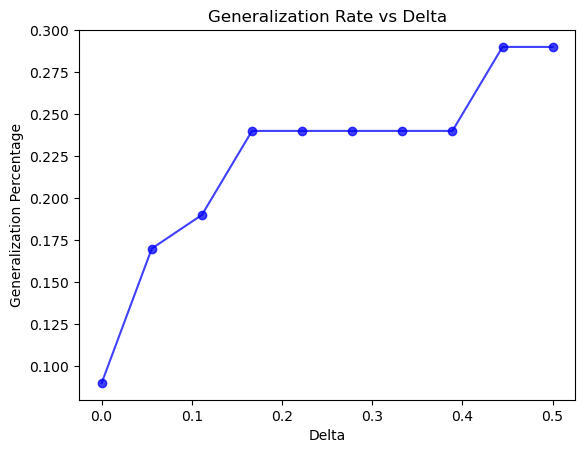

In [7]:
# Load the generator
generator = Generator().eval()
generator.load_state_dict(torch.load('./models/mnist/netG_epoch_99.pth', map_location=torch.device('cpu')))

# Generate Images
generated_images = generator.generate_images()

# Get features
_, train_features = classifier.predict(X_train)
_, test_features = classifier.predict(X_test)
_, generated_features = classifier.predict(generated_images)

# Compute generalization percentage for differnt values of delta
deltas = np.linspace(0.5, 0.0001, 10).tolist()
values = []
for i, delta in enumerate(deltas):
    value = calculate_generalization(train_features, test_features, generated_features, delta=delta)
    values.append(value)
    plt.scatter(delta, value, color=(0, 0, 1, 0.75))
plt.plot(deltas, values, c=(0, 0, 1, 0.75))
plt.title("Generalization Rate vs Delta")
plt.ylabel("Generalization Percentage")
plt.xlabel("Delta")

plt.show()